
=== Language: arabic (fastText: ar) ===
  stopwords: 701, in-model: 662, missing: 39


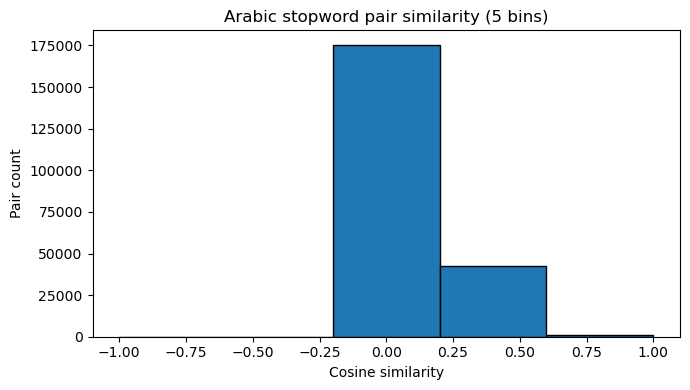

  Saved (relative):
   - artifacts/spec3_ar_similarity_pairs.csv
   - artifacts/spec3_ar_top5_similar.csv
   - artifacts/spec3_ar_top5_dissimilar.csv
   - artifacts/spec3_ar_similarity_hist.png

=== Language: french (fastText: fr) ===
  stopwords: 157, in-model: 153, missing: 4


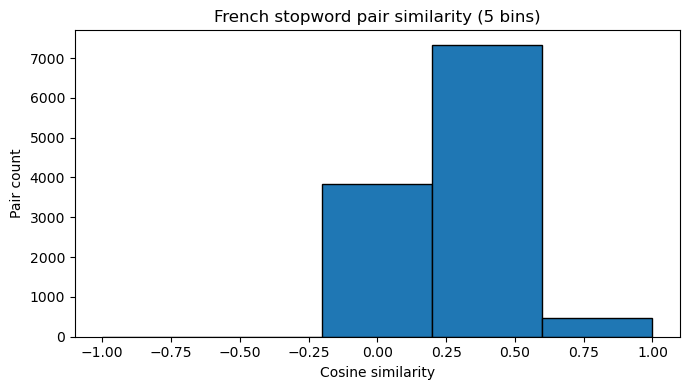

  Saved (relative):
   - artifacts/spec3_fr_similarity_pairs.csv
   - artifacts/spec3_fr_top5_similar.csv
   - artifacts/spec3_fr_top5_dissimilar.csv
   - artifacts/spec3_fr_similarity_hist.png

=== Language: spanish (fastText: es) ===
  stopwords: 313, in-model: 313, missing: 0


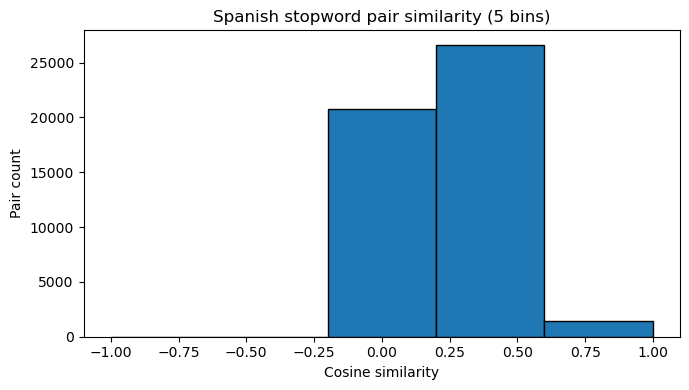

  Saved (relative):
   - artifacts/spec3_es_similarity_pairs.csv
   - artifacts/spec3_es_top5_similar.csv
   - artifacts/spec3_es_top5_dissimilar.csv
   - artifacts/spec3_es_similarity_hist.png

=== Language: german (fastText: de) ===
  stopwords: 232, in-model: 231, missing: 1


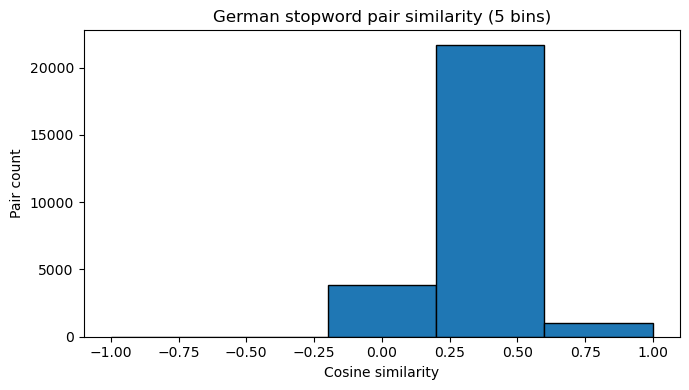

  Saved (relative):
   - artifacts/spec3_de_similarity_pairs.csv
   - artifacts/spec3_de_top5_similar.csv
   - artifacts/spec3_de_top5_dissimilar.csv
   - artifacts/spec3_de_similarity_hist.png

=== Language: italian (fastText: it) ===
  stopwords: 279, in-model: 279, missing: 0


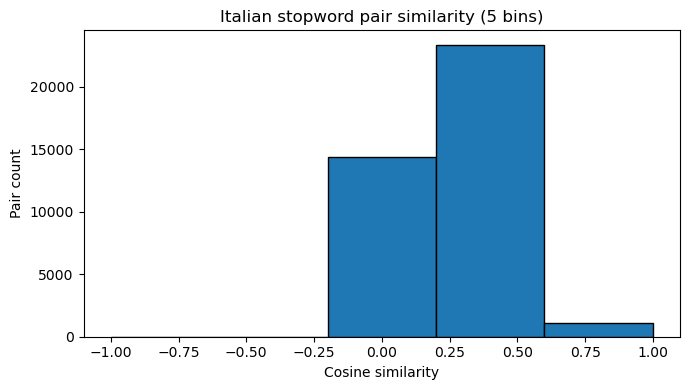

  Saved (relative):
   - artifacts/spec3_it_similarity_pairs.csv
   - artifacts/spec3_it_top5_similar.csv
   - artifacts/spec3_it_top5_dissimilar.csv
   - artifacts/spec3_it_similarity_hist.png

=== Summary saved (relative) ===
- artifacts/spec3_summary_languages.csv


,language,fasttext_code,stopwords_total,in_model,pairs,hist_png
0,arabic,ar,701,662,218791,spec3_ar_similarity_hist.png
1,french,fr,157,153,11628,spec3_fr_similarity_hist.png
2,spanish,es,313,313,48828,spec3_es_similarity_hist.png
3,german,de,232,231,26565,spec3_de_similarity_hist.png
4,italian,it,279,279,38781,spec3_it_similarity_hist.png


In [1]:
# Spec 3: Multilingual FastText similarity for stopword lists (5 languages)
# - Languages: Arabic, French, Spanish, German, Italian
# - For each language:
#   * load NLTK stopwords list
#   * load FastText model from data/ (bin/vec or gz)
#   * compute cosine similarity for every stopword pair
#   * save: full pairs CSV, top-5 similar, top-5 dissimilar, 5-bin histogram
#   * print clean relative paths
#
# All outputs go to artifacts/

import os, gzip, shutil, nltk, numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display

# --- paths (work from project root or notebooks/) ---
ART_DIR  = os.path.abspath("../artifacts" if os.path.basename(os.getcwd())=="notebooks" else "./artifacts")
DATA_DIR = os.path.abspath("../data"      if os.path.basename(os.getcwd())=="notebooks" else "./data")
os.makedirs(ART_DIR, exist_ok=True); os.makedirs(DATA_DIR, exist_ok=True)

# --- NLTK stopwords ---
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# --- language mapping: NLTK name -> fastText code ---
LANGS = [
    ("arabic",  "ar"),
    ("french",  "fr"),
    ("spanish", "es"),
    ("german",  "de"),
    ("italian", "it"),
]

# --- small helpers ---
def gunzip_once(src_gz, dst):
    """Decompress .gz file to dst if dst not exists."""
    if os.path.exists(src_gz) and not os.path.exists(dst):
        with gzip.open(src_gz, 'rb') as f_in, open(dst, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

def load_fasttext_model(lang_code):
    """Load fastText model for a given code from data/; supports .bin/.vec and .gz."""
    from gensim.models import KeyedVectors, fasttext as ft_api
    # candidates
    bin_path   = os.path.join(DATA_DIR, f"cc.{lang_code}.300.bin")
    vec_path   = os.path.join(DATA_DIR, f"cc.{lang_code}.300.vec")
    bin_gz     = bin_path + ".gz"
    vec_gz     = vec_path + ".gz"
    # decompress if needed
    if not os.path.exists(bin_path): gunzip_once(bin_gz, bin_path)
    if not os.path.exists(vec_path): gunzip_once(vec_gz, vec_path)
    # load
    if os.path.exists(bin_path):
        return ft_api.load_facebook_vectors(bin_path)   # binary facebook format
    if os.path.exists(vec_path):
        return KeyedVectors.load_word2vec_format(vec_path, binary=False)
    return None

def cosine_similarity_matrix(V):
    """Compute cosine similarity matrix for rows of V (n x d)."""
    # normalize rows
    norms = np.linalg.norm(V, axis=1, keepdims=True)
    norms[norms==0] = 1.0
    Vn = V / norms
    return np.dot(Vn, Vn.T)

def make_pairs_from_sim_matrix(words, S):
    """Upper-triangular pairs (i<j) -> (w_i, w_j, sim)."""
    n = len(words)
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((words[i], words[j], float(S[i,j])))
    return pairs

# --- main loop over languages ---
summary_rows = []

for nltk_name, ft_code in LANGS:
    print(f"\n=== Language: {nltk_name} (fastText: {ft_code}) ===")

    # stopwords list for the language
    try:
        L = sorted(set(stopwords.words(nltk_name)))
    except OSError:
        print(f"  [SKIP] NLTK stopwords not available for {nltk_name}.")
        continue

    if len(L) < 3:
        print(f"  [SKIP] Too few stopwords for {nltk_name} (|L|={len(L)}).")
        continue

    # load model
    model = load_fasttext_model(ft_code)
    if model is None:
        print(f"  [SKIP] fastText model not found for {ft_code}. "
              f"Put cc.{ft_code}.300.bin/vec(.gz) in data/ and re-run.")
        continue

    # keep only stopwords present in the model vocabulary
    vocab_words = [w for w in L if w in model.key_to_index]
    missing = len(L) - len(vocab_words)
    print(f"  stopwords: {len(L)}, in-model: {len(vocab_words)}, missing: {missing}")

    if len(vocab_words) < 3:
        print("  [SKIP] Not enough words in model vocab to build pairs.")
        continue

    # build matrix of vectors
    V = np.vstack([model.get_vector(w) for w in vocab_words])  # (n, 300)
    # similarity matrix (n x n)
    S = cosine_similarity_matrix(V)
    # flatten to pairs
    pairs = make_pairs_from_sim_matrix(vocab_words, S)
    df_sim = pd.DataFrame(pairs, columns=["word1","word2","similarity"])

    # save full pairs
    sim_csv  = os.path.join(ART_DIR, f"spec3_{ft_code}_similarity_pairs.csv")
    df_sim.to_csv(sim_csv, index=False)

    # top-5 similar / dissimilar
    top5 = df_sim.sort_values("similarity", ascending=False).head(5)
    bot5 = df_sim.sort_values("similarity", ascending=True ).head(5)
    top5_csv = os.path.join(ART_DIR, f"spec3_{ft_code}_top5_similar.csv")
    bot5_csv = os.path.join(ART_DIR, f"spec3_{ft_code}_top5_dissimilar.csv")
    top5.to_csv(top5_csv, index=False)
    bot5.to_csv(bot5_csv, index=False)

    # histogram with 5 equal bins over [-1, 1]
    bins = np.linspace(-1.0, 1.0, 6)
    plt.figure(figsize=(7,4))
    plt.hist(df_sim["similarity"].values, bins=bins, edgecolor="black")
    plt.title(f"{nltk_name.title()} stopword pair similarity (5 bins)")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Pair count")
    plt.tight_layout()
    hist_png = os.path.join(ART_DIR, f"spec3_{ft_code}_similarity_hist.png")
    plt.savefig(hist_png, dpi=150)
    plt.show()

    # print clean relative outputs
    print("  Saved (relative):")
    print(f"   - artifacts/{os.path.basename(sim_csv)}")
    print(f"   - artifacts/{os.path.basename(top5_csv)}")
    print(f"   - artifacts/{os.path.basename(bot5_csv)}")
    print(f"   - artifacts/{os.path.basename(hist_png)}")

    # collect summary
    summary_rows.append({
        "language": nltk_name,
        "fasttext_code": ft_code,
        "stopwords_total": len(L),
        "in_model": len(vocab_words),
        "pairs": len(df_sim),
        "hist_png": os.path.basename(hist_png)
    })

# --- summary CSV over all languages ---
if summary_rows:
    df_summary = pd.DataFrame(summary_rows)
    summary_csv = os.path.join(ART_DIR, "spec3_summary_languages.csv")
    df_summary.to_csv(summary_csv, index=False)
    print("\n=== Summary saved (relative) ===")
    print(f"- artifacts/{os.path.basename(summary_csv)}")
    display(df_summary)
else:
    print("\nNo language completed. Check models and stopword availability.")
